In [1]:
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings("ignore")


/Users/moiz/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Load the data
df = pd.read_csv('/Users/moiz/Desktop/IntrotoAI/cleaned_data.csv')

In [3]:
# Separate features and target
X = df.drop('HadHeartAttack', axis=1)
y = df['HadHeartAttack']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (356105, 39)
Testing set shape: (89027, 39)


In [4]:
# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'), categorical_features)
    ])

# Create and train Random Forest model
rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

rf_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours',
       'HeightInMeters', 'WeightInKilograms', 'BMI'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  Index(['State', 'Sex', 'GeneralHealth', 'LastCheckupTime',
       'PhysicalActiv...
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory', 'AgeCategory',
       'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver',
       'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos'],
      dtype='object'))])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [5]:
# Make predictions
y_pred = rf_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Baseline Random Forest Accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Baseline Random Forest Accuracy: 0.9452

Classification Report:
              precision    recall  f1-score   support

          No       0.95      1.00      0.97     83889
         Yes       0.64      0.11      0.19      5138

    accuracy                           0.95     89027
   macro avg       0.80      0.56      0.58     89027
weighted avg       0.93      0.95      0.93     89027




Oversampling Model:
Class distribution before sampling: HadHeartAttack
No     336135
Yes     19970
Name: count, dtype: int64
Class distribution after sampling: No     336135
Yes    336135
Name: count, dtype: int64

Undersampling Model:
Class distribution before sampling: HadHeartAttack
No     336135
Yes     19970
Name: count, dtype: int64
Class distribution after sampling: No     19970
Yes    19970
Name: count, dtype: int64
Oversampling Accuracy: 0.9443
Undersampling Accuracy: 0.7990

Oversampling Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.99      0.97     83889
         Yes       0.53      0.27      0.36      5138

    accuracy                           0.94     89027
   macro avg       0.75      0.63      0.67     89027
weighted avg       0.93      0.94      0.94     89027


Undersampling Classification Report:
              precision    recall  f1-score   support

          No       0.98      0.80      0.88     83889

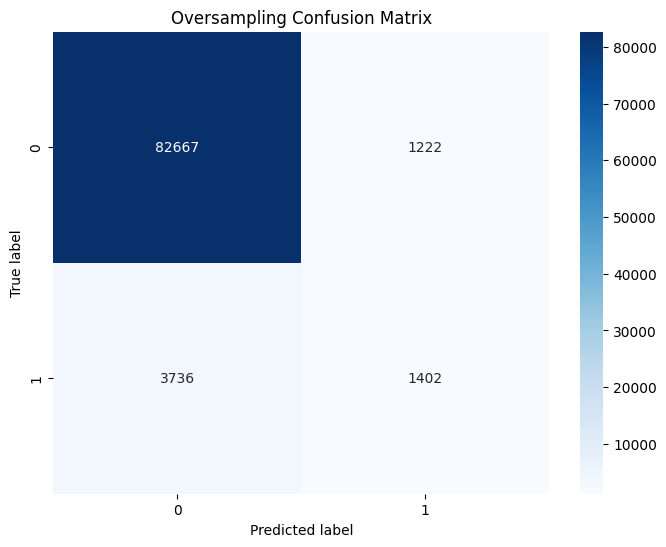

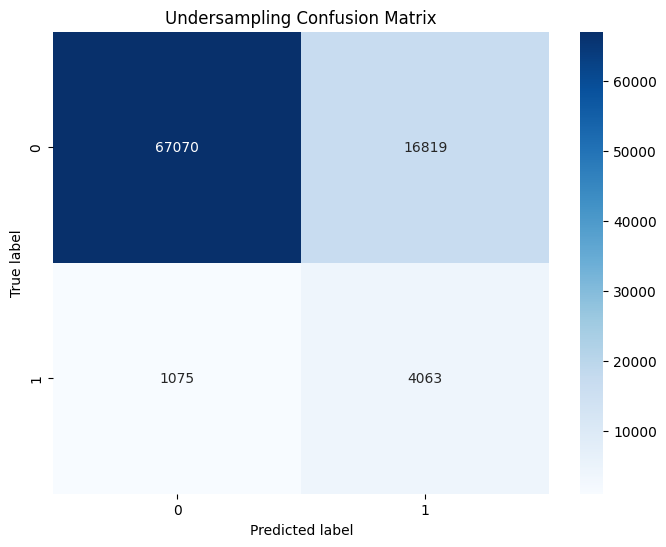

In [6]:
def train_evaluate_model(X_train, y_train, X_test, y_test, sampling=None):
    print(f"Class distribution before sampling: {y_train.value_counts()}")
    
    if sampling == 'oversample':
        # Separate majority and minority classes
        majority_class = X_train[y_train == y_train.value_counts().index[0]]
        minority_class = X_train[y_train == y_train.value_counts().index[1]]
        
        # Upsample minority class
        if len(majority_class) > 0:
            minority_upsampled = resample(minority_class,
                                          replace=True,     # sample with replacement
                                          n_samples=len(majority_class),    # to match majority class
                                          random_state=42)  # reproducible results
            
            # Combine majority class with upsampled minority class
            X_train_resampled = pd.concat([majority_class, minority_upsampled])
            y_train_resampled = pd.concat([pd.Series(y_train.value_counts().index[0], index=majority_class.index), 
                                           pd.Series(y_train.value_counts().index[1], index=minority_upsampled.index)])
        else:
            X_train_resampled, y_train_resampled = X_train, y_train
    
    elif sampling == 'undersample':
        # Separate majority and minority classes
        majority_class = X_train[y_train == y_train.value_counts().index[0]]
        minority_class = X_train[y_train == y_train.value_counts().index[1]]
        
        # Undersample majority class
        if len(minority_class) > 0:
            majority_downsampled = resample(majority_class,
                                            replace=False,    # sample without replacement
                                            n_samples=len(minority_class),     # to match minority class
                                            random_state=42)  # reproducible results
            
            # Combine minority class with downsampled majority class
            X_train_resampled = pd.concat([majority_downsampled, minority_class])
            y_train_resampled = pd.concat([pd.Series(y_train.value_counts().index[0], index=majority_downsampled.index), 
                                           pd.Series(y_train.value_counts().index[1], index=minority_class.index)])
        else:
            X_train_resampled, y_train_resampled = X_train, y_train
    
    else:
        X_train_resampled, y_train_resampled = X_train, y_train

    print(f"Class distribution after sampling: {y_train_resampled.value_counts()}")

    model = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    return accuracy, classification_report(y_test, y_pred), cm

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


# Oversampling
print("\nOversampling Model:")
over_acc, over_report, over_cm = train_evaluate_model(X_train, y_train, X_test, y_test, sampling='oversample')

# Undersampling
print("\nUndersampling Model:")
under_acc, under_report, under_cm = train_evaluate_model(X_train, y_train, X_test, y_test, sampling='undersample')

print(f"Oversampling Accuracy: {over_acc:.4f}")
print(f"Undersampling Accuracy: {under_acc:.4f}")

print("\nOversampling Classification Report:")
print(over_report)
print("\nUndersampling Classification Report:")
print(under_report)

# Plot confusion matrices
plot_confusion_matrix(over_cm, "Oversampling Confusion Matrix")
plot_confusion_matrix(under_cm, "Undersampling Confusion Matrix")

In [ ]:
# Define features and target
numeric_features = ['BMI', 'PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'WeightInKilograms', 'HeightInMeters']
categorical_features = ['State', 'Sex', 'GeneralHealth', 'LastCheckupTime', 'PhysicalActivities',
                        'RemovedTeeth', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 
                        'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 
                        'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty', 
                        'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing', 
                        'DifficultyErrands', 'SmokerStatus', 'ECigaretteUsage', 'ChestScan', 
                        'RaceEthnicityCategory', 'AgeCategory', 'AlcoholDrinkers', 'HIVTesting', 
                        'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos']
target = 'HadHeartAttack'

# Encode the target variable
le = LabelEncoder()
df[target] = le.fit_transform(df[target])

# Split the data
X = df[numeric_features + categorical_features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
    ])

# Create pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define parameter grid for GridSearchCV
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

# Create GridSearchCV object
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Get best model
best_model = grid_search.best_estimator_

# Make predictions on test set
y_pred = best_model.predict(X_test)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Feature importance
feature_importance = best_model.named_steps['classifier'].feature_importances_
feature_names = (numeric_features + 
                 best_model.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .get_feature_names_out(categorical_features).tolist())

# Sort feature importances in descending order
indices = np.argsort(feature_importance)[::-1]

# Print the feature ranking
print("\nFeature importance ranking:")
for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, feature_names[indices[f]], feature_importance[indices[f]]))

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), feature_importance[indices])
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()


Fitting 5 folds for each of 16 candidates, totalling 80 fits


/Users/moiz/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/moiz/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/moiz/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/moiz/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/moiz/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires ver